In [1]:
# -------------------------------
# Imports
# -------------------------------
import xarray as xr
import numpy as np
import plotly.graph_objects as go
import os
from scipy.interpolate import RegularGridInterpolator

# SETTINGS
input_folder = "/Users/danywaller/Projects/mercury/CPS_Base/object/"
out_folder = "/Users/danywaller/Projects/mercury/CPS_Base/3D_current/"
os.makedirs(out_folder, exist_ok=True)

# name of variables inside the NetCDF file
VAR_U = "Jx"   # x-component of current
VAR_V = "Jy"   # y-component of current
VAR_W = "Jz"   # z-component of current

# subsampling factor (3D quiver can get heavy)
SUB = 50

# first stable timestamp approx. 25000 for dt=0.002, numsteps=115000
sim_steps = list(range(27000, 115000 + 1, 1000))

R_m = 2440e3      # planetary radius
R_planet = 2240e3 # radius of sphere to plot


In [2]:
# Build planet sphere
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, np.pi, 30)
Xs = (R_planet / R_m) * np.outer(np.cos(u), np.sin(v))
Ys = (R_planet / R_m) * np.outer(np.sin(u), np.sin(v))
Zs = (R_planet / R_m) * np.outer(np.ones_like(u), np.cos(v))

sphere_mesh = go.Surface(
    x=Xs, y=Ys, z=Zs,
    colorscale=[[0, "lightgray"], [1, "lightgray"]],
    opacity=0.5,
    showscale=False
)


In [3]:
# Prepare frames
frames = []

for sim_step in sim_steps:
    filename = 'Base_' + "%06d" % sim_step

    f = input_folder + "Amitis_CPS_" + filename + "_xz_comp.nc"

    # print(f"Processing Amitis_CPS_{str(filename)}_xz_comp.nc ...")
    ds = xr.open_dataset(f)

    # Coordinates
    xmin = float(ds.full_xmin)
    xmax = float(ds.full_xmax)
    ymin = float(ds.full_ymin)
    ymax = float(ds.full_ymax)
    zmin = float(ds.full_zmin)
    zmax = float(ds.full_zmax)

    # Velocity
    U = ds[VAR_U].values
    V = ds[VAR_V].values
    W = ds[VAR_W].values

    while U.ndim > 3:  # remove time dim
        U = U[0]
        V = V[0]
        W = W[0]

    Nx, Ny, Nz = U.shape

    # Coordinates in planetary radius units
    x = np.linspace(xmin, xmax, Nx) / R_m
    y = np.linspace(ymin, ymax, Ny) / R_m
    z = np.linspace(zmin, zmax, Nz) / R_m
    Xg, Yg, Zg = np.meshgrid(x, y, z, indexing="ij")

    # Subsample for plotting
    Xp = Xg[::SUB, ::SUB, ::SUB]
    Yp = Yg[::SUB, ::SUB, ::SUB]
    Zp = Zg[::SUB, ::SUB, ::SUB]
    Up = U[::SUB, ::SUB, ::SUB]
    Vp = V[::SUB, ::SUB, ::SUB]
    Wp = W[::SUB, ::SUB, ::SUB]

    # Streamtube (streamlines) trace
    stream = go.Streamtube(
        x=Xp.flatten(),
        y=Yp.flatten(),
        z=Zp.flatten(),
        u=Up.flatten(),
        v=Vp.flatten(),
        w=Wp.flatten(),
        sizeref=0.1,               # tube thickness
        colorscale="Viridis",
        showscale=True,
        cmin=None,
        cmax=None,
        starts=dict(
            x=np.full(Yp[0,:,0].shape, x[0]),
            y=Yp[0,:,0],
            z=Zp[0,:,0]
        ),
        maxdisplayed=5000          # limit number of tubes
    )

    frames.append(go.Frame(data=[sphere_mesh, stream], name=f"timestep_{sim_step}"))
    ds.close()

print("Done!")

Done!


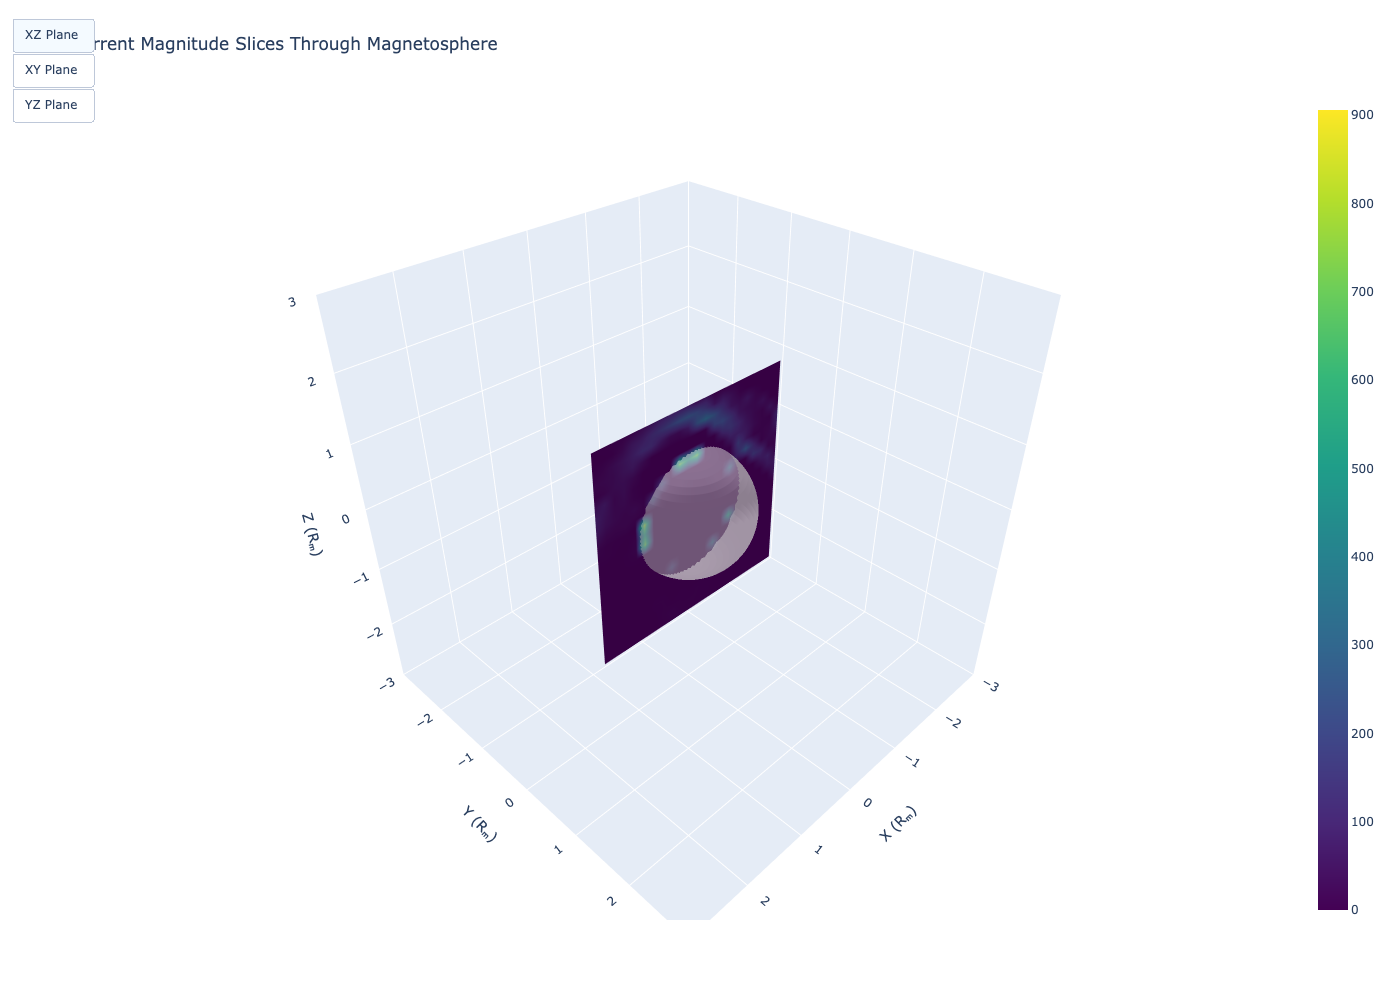

In [12]:
import os
import numpy as np
import xarray as xr
import plotly.graph_objects as go

# -------------------------------
# SETTINGS
# -------------------------------
input_folder = "/Users/danywaller/Projects/mercury/CPS_Base/object/"
VAR_U, VAR_V, VAR_W = "Jx", "Jy", "Jz"
SUB = 5
R_m = 2440e3
R_planet = 2240e3
THRESH = 50
sim_steps = list(range(27000, 115000 + 1, 1000))

# -------------------------------
# LOAD MEDIAN CURRENT
# -------------------------------
U_list, V_list, W_list = [], [], []

for sim_step in sim_steps:
    f = os.path.join(input_folder, f"Amitis_CPS_Base_{sim_step:06d}_xz_comp.nc")
    ds = xr.open_dataset(f)
    U, V, W = ds[VAR_U].values, ds[VAR_V].values, ds[VAR_W].values
    while U.ndim > 3:
        U, V, W = U[0], V[0], W[0]
    U_list.append(U)
    V_list.append(V)
    W_list.append(W)
    ds.close()

U_med = np.median(np.stack(U_list, axis=0), axis=0)
V_med = np.median(np.stack(V_list, axis=0), axis=0)
W_med = np.median(np.stack(W_list, axis=0), axis=0)

# -------------------------------
# GRID COORDINATES
# -------------------------------
ds0 = xr.open_dataset(os.path.join(input_folder, f"Amitis_CPS_Base_{sim_steps[0]:06d}_xz_comp.nc"))
Nx, Ny, Nz = U_med.shape
x = np.linspace(float(ds0.full_xmin), float(ds0.full_xmax), Nx) / R_m
y = np.linspace(float(ds0.full_ymin), float(ds0.full_ymax), Ny) / R_m
z = np.linspace(float(ds0.full_zmin), float(ds0.full_zmax), Nz) / R_m
ds0.close()

Xg, Yg, Zg = np.meshgrid(x, y, z, indexing='ij')
J_mag = np.sqrt(U_med**2 + V_med**2 + W_med**2)

# -------------------------------
# SUBSAMPLE AND MASK
# -------------------------------
Xp, Yp, Zp = Xg[::SUB, ::SUB, ::SUB], Yg[::SUB, ::SUB, ::SUB], Zg[::SUB, ::SUB, ::SUB]
Jp = J_mag[::SUB, ::SUB, ::SUB]

# -------------------------------
# PLANET SPHERE
# -------------------------------
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, np.pi, 30)
Xs = (R_planet / R_m) * np.outer(np.cos(u), np.sin(v))
Ys = (R_planet / R_m) * np.outer(np.sin(u), np.sin(v))
Zs = (R_planet / R_m) * np.outer(np.ones_like(u), np.cos(v))

sphere = go.Surface(x=Xs, y=Ys, z=Zs, colorscale=[[0,"lightgray"],[1,"lightgray"]],
                    opacity=0.5, showscale=False)

# -------------------------------
# CREATE SLICES
# -------------------------------
# XZ slice at Y = center
y_center_idx = Yp.shape[1] // 2
slice_XZ = go.Surface(
    x=Xp[:, y_center_idx, :].T,
    y=Yp[:, y_center_idx, :].T,
    z=Zp[:, y_center_idx, :].T,
    surfacecolor=Jp[:, y_center_idx, :].T,
    colorscale="Viridis",
    cmin=Jp.min(),
    cmax=Jp.max(),
    showscale=True,
    visible=True
)

# XY slice at Z = center
z_center_idx = Zp.shape[2] // 2
slice_XY = go.Surface(
    x=Xp[:, :, z_center_idx].T,
    y=Yp[:, :, z_center_idx].T,
    z=Zp[:, :, z_center_idx].T,
    surfacecolor=Jp[:, :, z_center_idx].T,
    colorscale="Viridis",
    cmin=Jp.min(),
    cmax=Jp.max(),
    showscale=True,
    visible=False
)

# YZ slice at X = center
x_center_idx = Xp.shape[0] // 2
slice_YZ = go.Surface(
    x=Xp[x_center_idx, :, :].T,
    y=Yp[x_center_idx, :, :].T,
    z=Zp[x_center_idx, :, :].T,
    surfacecolor=Jp[x_center_idx, :, :].T,
    colorscale="Viridis",
    cmin=Jp.min(),
    cmax=Jp.max(),
    showscale=True,
    visible=False
)

# -------------------------------
# TOGGLE BUTTONS
# -------------------------------
fig = go.Figure(data=[sphere, slice_XZ, slice_XY, slice_YZ])

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            showactive=True,
            x=0.0,
            y=1.1,
            buttons=[
                dict(label="XZ Plane",
                     method="update",
                     args=[{"visible":[True, True, False, False]}]),
                dict(label="XY Plane",
                     method="update",
                     args=[{"visible":[True, False, True, False]}]),
                dict(label="YZ Plane",
                     method="update",
                     args=[{"visible":[True, False, False, True]}]),
            ]
        )
    ],
    scene=dict(
        xaxis=dict(range=[-3, 3], title="X (Rₘ)"),
        yaxis=dict(range=[-3, 3], title="Y (Rₘ)"),
        zaxis=dict(range=[-3, 3], title="Z (Rₘ)"),
        aspectmode="cube"
    ),
    width=1000,
    height=1000,
    title="Current Magnitude Slices Through Magnetosphere"
)

fig.show()


-728.0497 643.9879
-753.91187 794.94366
-481.2336 751.49756


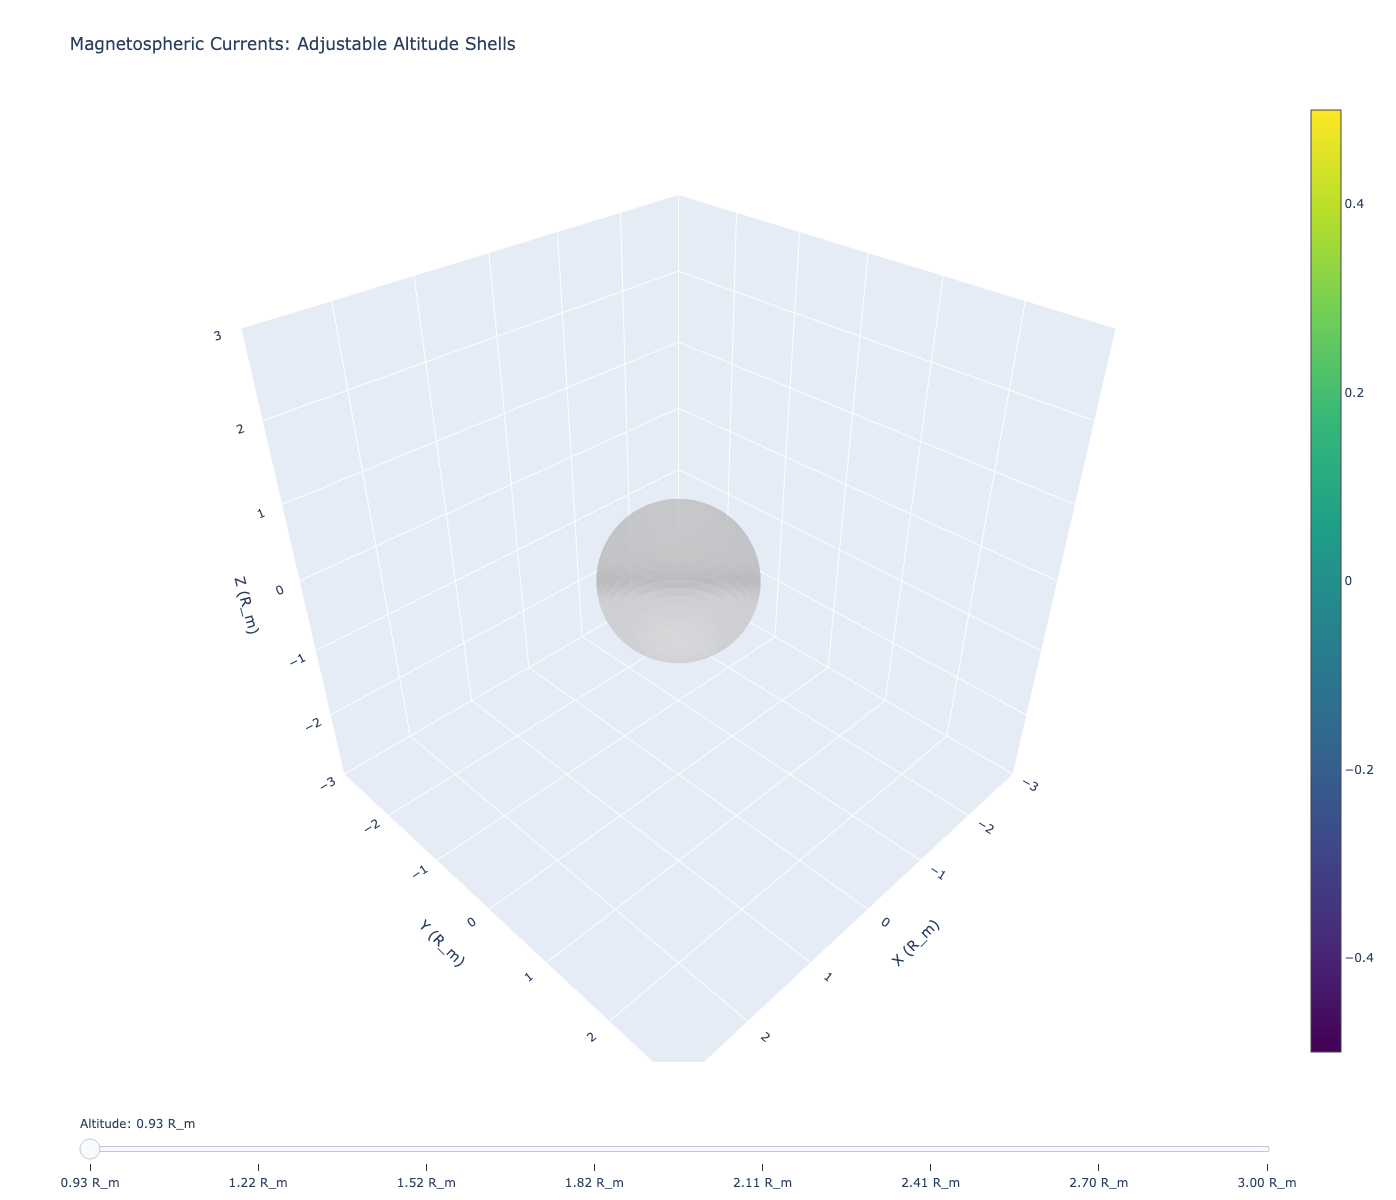

In [5]:
import os
import numpy as np
import xarray as xr
import plotly.graph_objects as go

# -------------------------------
# SETTINGS
# -------------------------------
input_folder = "/Users/danywaller/Projects/mercury/CPS_Base/object/"
VAR_U, VAR_V, VAR_W = "Jx", "Jy", "Jz"
SUB = 5
R_m = 2440e3
R_planet = 2240e3
THRESH = 5
sim_steps = list(range(27000, 115000 + 1, 1000))

# -------------------------------
# LOAD AND MEDIAN CURRENT
# -------------------------------
U_list, V_list, W_list = [], [], []

for sim_step in sim_steps:
    f = os.path.join(input_folder, f"Amitis_CPS_Base_{sim_step:06d}_xz_comp.nc")
    ds = xr.open_dataset(f)
    U, V, W = ds[VAR_U].values, ds[VAR_V].values, ds[VAR_W].values
    while U.ndim > 3:
        U, V, W = U[0], V[0], W[0]
    U_list.append(U)
    V_list.append(V)
    W_list.append(W)
    ds.close()

U_med = np.median(np.stack(U_list, axis=0), axis=0)
V_med = np.median(np.stack(V_list, axis=0), axis=0)
W_med = np.median(np.stack(W_list, axis=0), axis=0)

# -------------------------------
# GRID COORDINATES
# -------------------------------
ds0 = xr.open_dataset(os.path.join(input_folder, f"Amitis_CPS_Base_{sim_steps[0]:06d}_xz_comp.nc"))
Nx, Ny, Nz = U_med.shape
x = np.linspace(float(ds0.full_xmin), float(ds0.full_xmax), Nx) / R_m
y = np.linspace(float(ds0.full_ymin), float(ds0.full_ymax), Ny) / R_m
z = np.linspace(float(ds0.full_zmin), float(ds0.full_zmax), Nz) / R_m
ds0.close()

Xg, Yg, Zg = np.meshgrid(x, y, z, indexing='ij')

# -------------------------------
# SUBSAMPLE AND MASK WEAK CURRENTS
# -------------------------------
Xp, Yp, Zp = Xg[::SUB, ::SUB, ::SUB], Yg[::SUB, ::SUB, ::SUB], Zg[::SUB, ::SUB, ::SUB]
Up, Vp, Wp = U_med[::SUB, ::SUB, ::SUB], V_med[::SUB, ::SUB, ::SUB], W_med[::SUB, ::SUB, ::SUB]

J_mag = np.sqrt(Up**2 + Vp**2 + Wp**2)
mask = J_mag > THRESH
Xp_masked, Yp_masked, Zp_masked = Xp[mask], Yp[mask], Zp[mask]
Up_masked, Vp_masked, Wp_masked = Up[mask], Vp[mask], Wp[mask]
J_mag_flat = J_mag[mask]

print(np.min(Up_masked), np.max(Up_masked))
print(np.min(Vp_masked), np.max(Vp_masked))
print(np.min(Wp_masked), np.max(Wp_masked))

# -------------------------------
# PLANET SPHERE
# -------------------------------
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, np.pi, 30)
Xs = (R_planet / R_m) * np.outer(np.cos(u), np.sin(v))
Ys = (R_planet / R_m) * np.outer(np.sin(u), np.sin(v))
Zs = (R_planet / R_m) * np.outer(np.ones_like(u), np.cos(v))

sphere = go.Surface(x=Xs, y=Ys, z=Zs, colorscale=[[0,"lightgray"],[1,"lightgray"]],
                    opacity=0.5, showscale=False)

# -------------------------------
# DEFINE SHELLS AND FRAMES
# -------------------------------
shell_radii = np.linspace(R_planet / R_m * 1.01, 3.0, 8)  # 8 shells from surface to 3 R_m
frames = []

for r_shell in shell_radii:
    r = np.sqrt(Xp_masked**2 + Yp_masked**2 + Zp_masked**2)
    shell_mask = (r >= r_shell - 0.05) & (r <= r_shell + 0.05)  # shell thickness ±0.05
    starts_x, starts_y, starts_z = Xp_masked[shell_mask], Yp_masked[shell_mask], Zp_masked[shell_mask]

    # pick subset if too many points
    Nmax = 100
    if len(starts_x) > Nmax:
        idx = np.random.choice(len(starts_x), Nmax, replace=False)
        starts_x, starts_y, starts_z = starts_x[idx], starts_y[idx], starts_z[idx]

    stream = go.Streamtube(
        x=Xp_masked.flatten(),
        y=Yp_masked.flatten(),
        z=Zp_masked.flatten(),
        u=Up_masked.flatten(),
        v=Vp_masked.flatten(),
        w=Wp_masked.flatten(),
        starts=dict(x=starts_x, y=starts_y, z=starts_z),
        colorscale="Viridis",
        sizeref=0.1,
        maxdisplayed=20000,
        showscale=True
    )
    frames.append(go.Frame(data=[sphere, stream], name=f"r_{r_shell:.2f}"))

# -------------------------------
# CREATE FIGURE WITH SLIDER
# -------------------------------
fig = go.Figure(
    data=frames[0].data,
    frames=frames
)

steps = []
for i, r_shell in enumerate(shell_radii):
    step = dict(
        method="animate",
        args=[[frames[i].name], dict(mode="immediate", frame=dict(duration=500, redraw=True), transition=dict(duration=0))],
        label=f"{r_shell:.2f} R_m"
    )
    steps.append(step)

sliders = [dict(active=0, currentvalue={"prefix":"Altitude: "}, pad={"t":50}, steps=steps)]

fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-3,3], title="X (R_m)"),
        yaxis=dict(range=[-3,3], title="Y (R_m)"),
        zaxis=dict(range=[-3,3], title="Z (R_m)"),
        aspectmode="data"
    ),
    width=1200,
    height=1200,
    title="Magnetospheric Currents: Adjustable Altitude Shells",
    sliders=sliders
)

fig.show()
